<a href="https://colab.research.google.com/github/YanaKhlusova/ML_course/blob/main/khlusova_task1_titanic_logreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`machine learning course 2025 (с) mssvctr`

### Домашнее задание 1

**Titanic challenge** - самое известное соревнование по Data Science

Используйте данные о пассажирах Титаника, чтобы построить свой классификатор, который предсказывает вероятность гибели пассажира на печально известном корабле

#### Шаг 1: импорт библиотек

Заполните плейсхолдеры

In [ ]:
# импортируйте pandas, numpy, seaborn и matplotlib
# не забывайте о том, что каждая из этих библиотек
# использует свои сокращения

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# далее мы импортируем миллион методов из scikit-learn
# эта часть уже выполнена, ура!

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#### Шаг 2: загружаем данные с Титаника

In [ ]:
# выгрузим датасет напрямую с URL
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

# выведите первые 5 строк датасета
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Шаг 3: анализ данных

Опишите данные и укажите в комментариях к коду ответы на вопросы:

1. выведите df.info()
  - в каких столбцах есть NaN'ы?
  - ориентируясь на количество NaN'ов в столбцах, определите, какие строки "не жалко" выбросить, а какие лучше сохранить
2. визуализируйте распределение классов по столбцу `Survived`
  - сбалансировали ли классы в нашем датасете?
3. выведите список столбцов, в которых представлены категориальные данные
  - почему категориальные данные нужно будет обработать перед запуском обучения модели?

In [ ]:
df.info()

# точно можно дропнуть Cabin, поскольку ненулевых более, чем в 4 раза меньше, чем в строк в датасете
# но учитывая, что наша цель, предсказать выживаемость, кабина могла бы стать неплохим предиктором - как далеко нужно было двигаться пассажиру до шлюпок?
# остальные оставим, хотя возраст вызывает вопросы
# возраст тоже может пригодиться: кому легче выжить, детям, 20-30-летним людям, людям старше?
# в Embarked пропущены всего 2 значения, оставим, остальные полные
# столбец Survived нужен по умолчанию)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


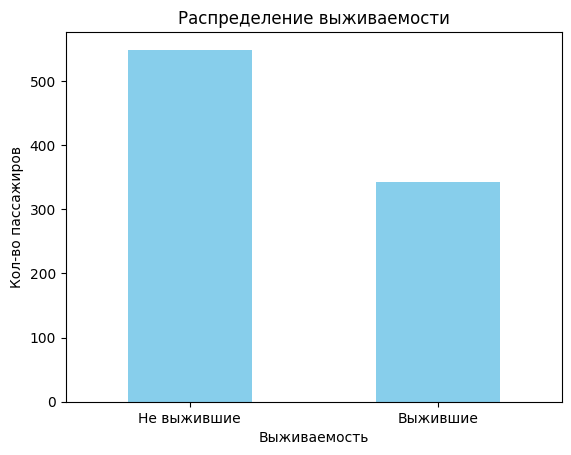

In [ ]:
df['Survived'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Распределение выживаемости')
plt.xlabel('Выживаемость')
plt.ylabel('Кол-во пассажиров')
text_labels = ['Не выжившие', 'Выжившие']
plt.xticks(ticks=range(len(text_labels)), labels=text_labels, rotation=0)
plt.show()

# классы не сбалансированы, невыживших на ~ 200 больше, чем выживших
# Для читаемости графика заменяю 0 и 1 на лейблы

In [ ]:
df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Fare'], axis =1).head()

# NaN'ы могут исказить данные и результаты работы модели
# если у нас слишком много лейблов в категориях (как в Age), они будут неинформативными
# стоит глянуть, имеют ли смысл категории SibSp и	Parch

,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked
0,0,3,male,22.0,1,0,NaN,S
1,1,1,female,38.0,1,0,C85,C
2,1,3,female,26.0,0,0,NaN,S
3,1,1,female,35.0,1,0,C123,S
4,0,3,male,35.0,0,0,NaN,S


#### Шаг 4: анализ данных

Ответы на эти вопросы помогут вам принять решения для препроцессинга данных:

- требуется ли балансировка классов?
- какие столбцы нужно дропнуть?
- какие данные нужно преобразовать к виду числовых?

In [ ]:
df.drop(columns=['PassengerId', 'Survived', 'Pclass'], axis =1).describe() # хочу посмотреть, что с числами
# айди, выживаемость и класс проигнорируем
# возраст сильно разбросан, от младенцев до 80-летних людей
# кол-во сиблингов/супругов как-будто бы бесполезно - среднее меньше 1, ст. откл. 1, следовательно, значения в основном колеблются вокруг 1
# то же и самое и про родителей с детьми
# стоимость лучше выкину, значения точно не сбалансированы и есть социально-экономические классы
# думаю, что если чем выше у человека класс, тем больше он может отдать за билет
# интересно, это кто у нас за бесплатно проехал??

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


In [ ]:
df.loc[df['Fare'] == 0]
# ?? как??

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


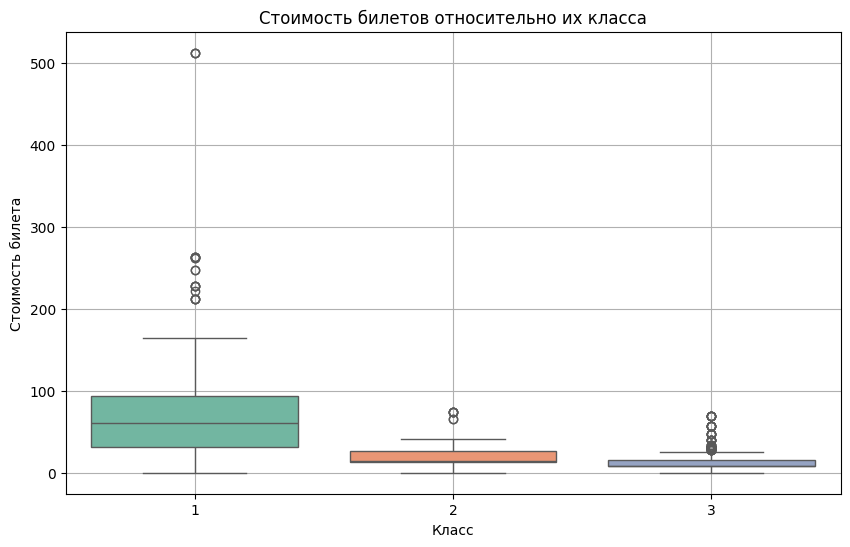

In [ ]:
# гипотеза про стоимость и классы
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Pclass', y='Fare', hue='Pclass', palette='Set2', legend=False)
plt.title('Стоимость билетов относительно их класса')
plt.xlabel('Класс')
plt.ylabel('Стоимость билета')
plt.grid(True)
plt.show()

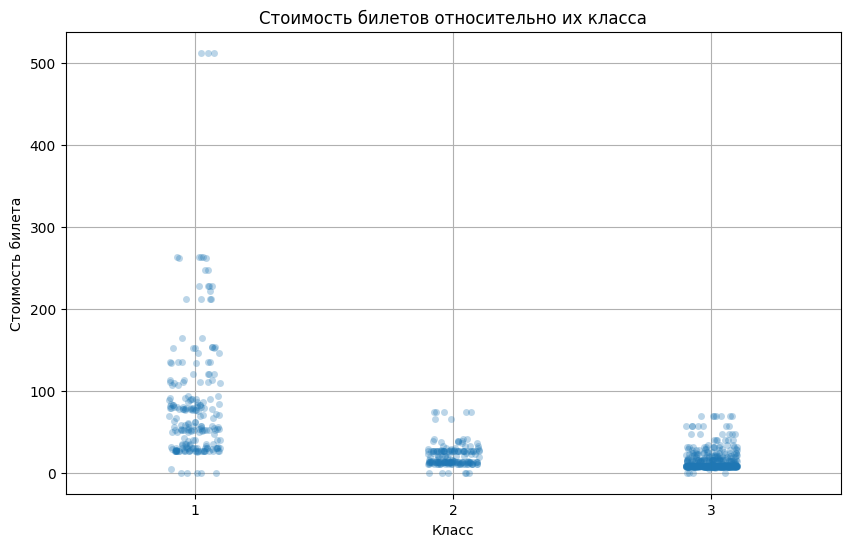

In [ ]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=df, x='Pclass', y='Fare', alpha=0.3)
plt.title('Стоимость билетов относительно их класса')
plt.xlabel('Класс')
plt.ylabel('Стоимость билета')
plt.grid(True)
plt.show()
# ну... не совсем, разницы между 2 и 3 классом как-будто нет
# 3-й класс даже подороже билеты брал
# хотя, опять же, сколько у нас наблюдений каждого класса?

In [ ]:
df.value_counts('Pclass')
# несбалансированно, я бы не опиралась на класс билета при предсказании выживаемости - 3-его элементарно больше чем остальных вместе взятых
# разве если вместо трех классов сделать 2 - 1-ый и 2-ой VS. 3-ий
# но если говорить о деньгах, 1-ый класс заплатил явно больше - тогда смешивать его со вторым не очень грамотно
# с другой стороны, можно проверить, больше или меньше шансов выжить, если человек плыл 3-им классом

,count
Pclass,
3,491
1,216
2,184


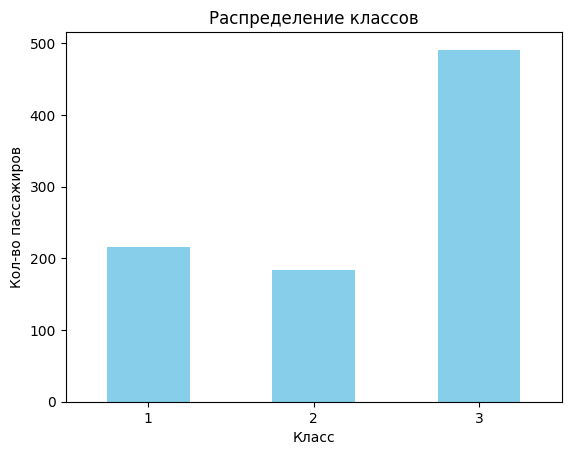

In [ ]:
# отрисую для наглядности
df['Pclass'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Распределение классов")
plt.xlabel('Класс')
plt.ylabel('Кол-во пассажиров')
plt.xticks(rotation=0)
plt.show()

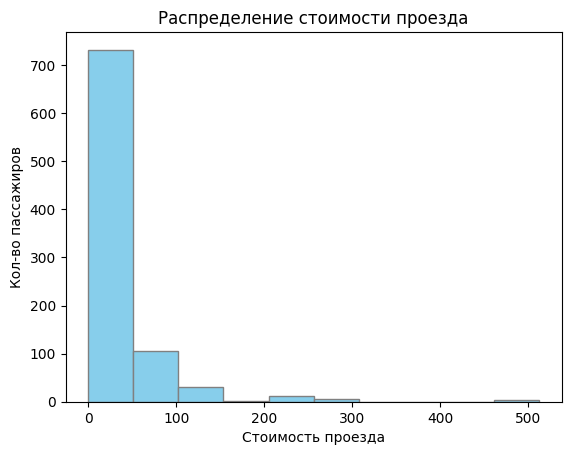

In [ ]:
# нужна ли нам стоимость проезда?
# у нее слишком много значений, мне не понятно пока, как грамотно сделать категории - по-другому оставлять нельзя, только разбить на интервалы
# построю гистограмму
plt.hist(df['Fare'], edgecolor='gray', color='skyblue')
plt.title('Распределение стоимости проезда')
plt.xlabel('Стоимость проезда')
plt.ylabel('Кол-во пассажиров')
plt.show()
# в основном значения находятся в промежутке от 0 до ~150 (? долларов)
# лучше дропну, яснее не стало...

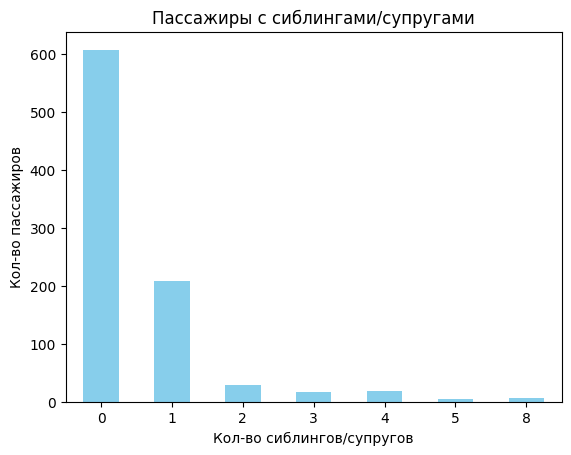

In [ ]:
# идем дальше
df['SibSp'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Пассажиры с сиблингами/супругами')
plt.xlabel('Кол-во сиблингов/супругов')
plt.ylabel('Кол-во пассажиров')
plt.xticks(rotation=0)
plt.show()

# ну как я и сказала выше, параметр в целом бесполезный - большинство людей путешествовали в одиночку

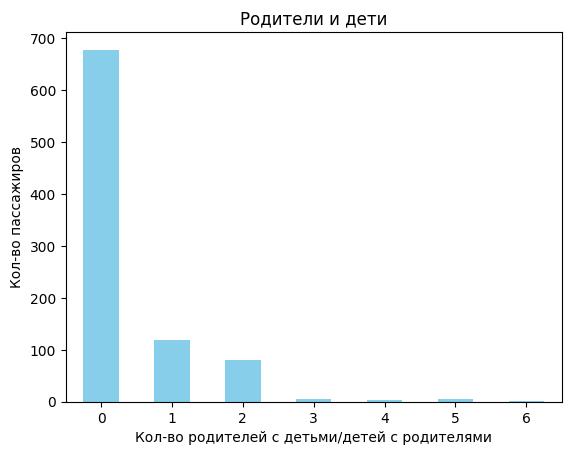

In [ ]:
df['Parch'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Родители и дети')
plt.xlabel('Кол-во родителей с детьми/детей с родителями')
plt.ylabel('Кол-во пассажиров')
plt.xticks(rotation=0)
plt.show()

# тоже в основном родители без детей/дети без родителей

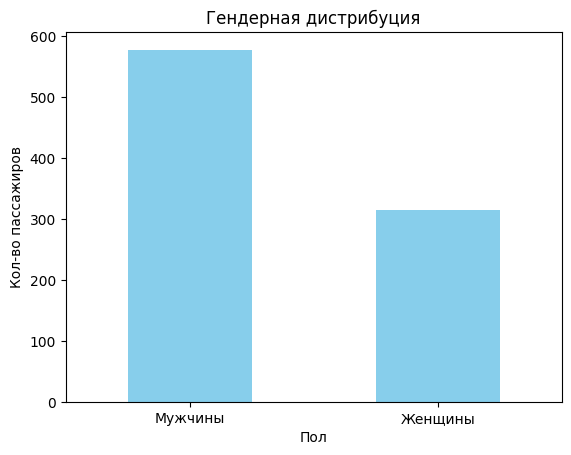

In [ ]:
df['Sex'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Гендерная дистрибуция")
plt.xlabel('Пол')
plt.ylabel('Кол-во пассажиров')
text_labels = ['Мужчины', 'Женщины']
plt.xticks(ticks=range(len(text_labels)), labels=text_labels, rotation=0)
plt.show()

# well... ok?

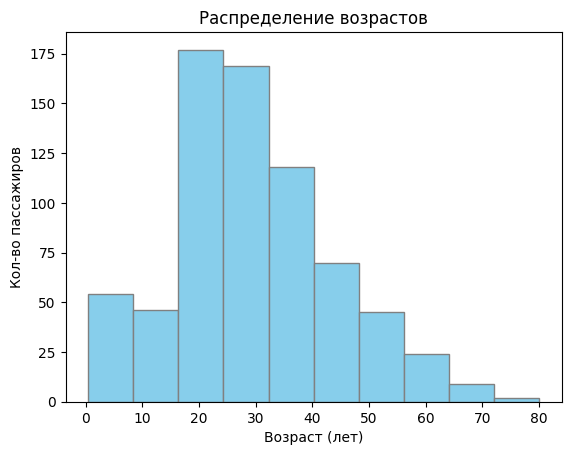

In [ ]:
# отрисую так же возрастное распределение
plt.hist(df['Age'], edgecolor='gray', color='skyblue')
plt.title('Распределение возрастов')
plt.xlabel('Возраст (лет)')
plt.ylabel('Кол-во пассажиров')
plt.show()
# похоже даже на нормальное распределение .о.
# оставляем, но позже нужно будет придумать промежутки для категорий ("абсолютными значениями" оставлять нельзя - слишком много лейблов)

In [ ]:
# а что у нас с номерами билетов, нужен ли этот столбец?
df.value_counts('Ticket')
# как может билет с одним номером принадлежать нескольким людям?..

,count
Ticket,
1601,7
CA. 2343,7
347082,7
CA 2144,6
3101295,6
...,...
112052,1
112050,1
111428,1


In [ ]:
df.loc[df['Ticket'] == 'CA. 2343'] # понятно, это одна семья
# они все умерли -.-

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [ ]:
df.loc[df['Ticket'] == '1601'] # кто-то выжил, кто-то нет, и не похоже на одну семью
# стоимость одинаковая, интересно, это люди скинулись на один билет или Ticket все-таки не номер билета, а его тип...
# судя по соц.эк. классу и стоимости билета, кажется, что скинулись

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
74,75,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S
169,170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S
509,510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S
643,644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S
838,839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S


**Дропаем столбцы**

Оставим классы в покое и сразу перейдем к очистке таблицы

Есть два пути:

- дропнуть "лишние" столбцы из исходной таблицы
- создать новую таблицу, в которую мы занесем только "нужные" столбцы

Выберите любой способ и создайте новый датафрейм, очищенный от неинформативных столбцов, в которых много NaN'ов

In [ ]:
"""
ПРИМЕР ОЧИЩЕННОЙ ТАБЛИЦЫ
"""

'\nПРИМЕР ОЧИЩЕННОЙ ТАБЛИЦЫ\n'

In [ ]:
# итак, по эксплораторному анализу выше, я решила удалить следующие столбцы:
df = df.drop(columns=['PassengerId', 'Fare', 'Cabin', 'Name', 'Ticket'], axis =1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


**Categorical --> Numerical**

Для преобразования категориальных данных к виду чисел, в sklearn используется метод `LabelEncoder`

- документация [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

Метод автоматически заменяет категориальные метки на целые числа

In [ ]:
# образец кодирования столбца 'Sex' с LabelEncoder
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])  # 0 = female, 1 = male
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,1,22.0,1,0,S
1,1,1,0,38.0,1,0,C
2,1,3,0,26.0,0,0,S
3,1,1,0,35.0,1,0,S
4,0,3,1,35.0,0,0,S


Рассмотрим еще один метод: мы имитируем one-hot encoding с помощью метода `get_dummies` из Pandas

- [документация метода](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)

Принцип работы one-hot-encoding:

- как мы закодируем цифры 1 и 9, чтобы получить разреженный массив?
- создаем матрицу из двух векторов размерностью 10
  ```
  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] # цифра 1
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1] # цифра 9
  ```
- единица означает позицию цифры в ряде `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`
- также:
  - единица означает `True` (число находится в этой позиции)
  - ноль означает `False` (число не находится в этой позиции)

При использовании этого метода в датафреймах, мы также создаем три новых столбца (три новых вектора), в которых помечаем `True` соответствие данной метке

In [ ]:
# образец кодирования столбца 'Embarked' с get_dummies
# в Embarked у нас три метки: C, Q, S
# метки означают станцию посадки данного пассажира
df = pd.get_dummies(df, columns=['Embarked'])  # one-hot encoding
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,False,False,True
1,1,1,0,38.0,1,0,True,False,False
2,1,3,0,26.0,0,0,False,False,True
3,1,1,0,35.0,1,0,False,False,True
4,0,3,1,35.0,0,0,False,False,True


Теперь обновите ваш датафрейм: замените с использованием изученных методов категориальные данные на числовые

Изучите документацию и найдите дополнительные материалы, ответьте на вопрос: чем `LabelEncoder` отличается от `get_dummies` и когда какой метод лучше использовать?

`LabelEncoder` подойдет для порядковых категориальных переменных, `get_dummies` --- для номинальных. Если использовать `LabelEncoder` для кодирования номинальных переменных, создаться излишняя числовая иерархия, что может исказить поведение модели машинного обучения. В этом случае лучше просто отметить есть ли признак (`True` VS. `False`).

Но моей первой мыслью было, что `LabelEncoder` подойдет для бинарных переменных, чтобы не увеличивать размер датасета = занимать меньше памяти. Видимо, поэтому выше пол пассажира преобразован в числа именно этим методом.

**Заполняем пропуски**

Мы убрали лишние столбцы, но NaN'ы по-прежнему есть в нашем датафрейме

Рассмотрим метод `SimpleImputer` из sklearn для заполнения пропусков в данных

- [документация SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

In [ ]:
# для того, чтобы выбрать стратегию заполнения пропусков, проведу тест на нормальность распределения чисел в столбце Age
from scipy import stats

stats.shapiro(df['Age'].dropna())

# судя по p-value (и графику в начале блокнота), данные распределены нормально, можно остановится на mean

ShapiroResult(statistic=np.float64(0.9814577414504954), pvalue=np.float64(7.337348958673594e-08))

In [ ]:
# заполняем пропуски в столбце Age
imputer = SimpleImputer(strategy="mean")
df['Age'] = imputer.fit_transform(df[['Age']])

Изучите документацию sklearn и ответьте на вопросы: какие стратегии доступы для работы с методом SimpleImputer? Чем они отличаются? Какие стратегии подойдут для работы с категориальными данными?

**Стратегии для работы с методом SimpleImputer**

Если мы просто так добавим значения в выборку, она станет другой. Нам же нужно оставить свойства оригинального датасета. Какие свойства есть у выборки? Описательные статистики --- среднее, медиана, мода. Вот эти стратегии (и некоторые другие) и есть у SimpleImputer.

`mean` --- вставляем среднее по столбцу (для числовых переменных);
`median` --- вставляем медиану столбца (для числовых переменных);
`most_frequent` --- вставляем моду столбца (и числовые, и строковые). Если есть несколько вариантов наиболее частого значения переменной, вставляем меньшее из них;
`constant` --- сами задаем константу, для чисел - число, для объектов - строку. Если не зададим, для чисел автоматически будет использоваться 0, для строк - missing_value;
`Callable` --- используем кастомную функцию для вычисления значения, которое будет вставлено вместо пропусков (для числовых переменных).

Итак, для категорий подойдут `most_frequent` и `constant`.



**Feature Engineering**

> Данные - это пища для вашей модели

Слишком шумные данные вызовут отравление модели (кстати, один из методов киберпреступности, построенный на работе с данными, так и называется - data poisoning!)

Недостаточность в данных может стать причиной недообучения (underfitting), поэтому мы можем не только дропать, но и добавлять фичи, т.е. признаки, на которых будет учиться наша модель

Этот процесс называется **feature engineering**

In [ ]:
# Добавим фичу Family size = SibSp + Parch + 1 (единица обозначает самого пассажира)
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# Фича Alone для тех, кто путешествует один
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked_C,Embarked_Q,Embarked_S,FamilySize,IsAlone
0,0,3,1,22.0,1,0,False,False,True,2,0
1,1,1,0,38.0,1,0,True,False,False,2,0
2,1,3,0,26.0,0,0,False,False,True,1,1
3,1,1,0,35.0,1,0,False,False,True,2,0
4,0,3,1,35.0,0,0,False,False,True,1,1


Добавьте любую новую фичу в датафрейм, которая легко выводится из данных

Например, можно вытащить обращения к пассажирам из столбца `Name` из исходной таблицы: `Mr., Mrs., Dr.`

Для этого изучите внимательно данные, познакомьтесь с описанием датасета на Kaggle

- https://www.kaggle.com/c/titanic/

Вам нужно самостоятельно решить, что можно извлечь из этих данных, как назвать новую фичу и избавиться от категориальных меток

In [ ]:
# я видела в обсуждениях на Kaggle, что добавление обращений повышает accuracy, но я совершенно не понимаю, ЧТО концептуально эта фича дает, поэтому не буду ее делать
# ну и зачем повторяться
# вместо этого заменю абсолютный возраст на категории

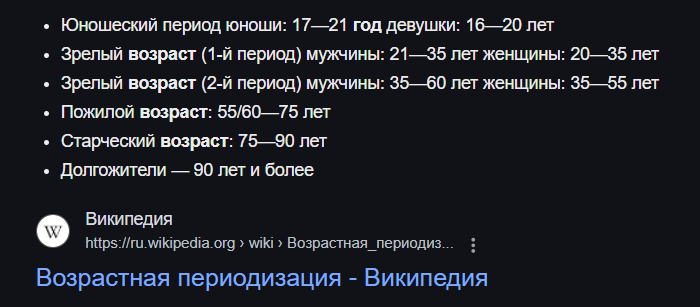

Немного модернизирую:

- 0-10 лет --- дети,
- 11-18 лет --- подростки,
- 19-35 --- молодые люди,
- 36-59 --- взрослые люди,
- 60-80 --- люди в возрасте.

In [ ]:
bins = [0, 10, 18, 35, 59, 80]
labels = ['children', 'teenagers', 'young_people', 'adults', 'elderly']

df['Age_category'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True, include_lowest=True)

df.head(20)

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked_C,Embarked_Q,Embarked_S,FamilySize,IsAlone,Age_category
0,0,3,1,22.000000,1,0,False,False,True,2,0,young_people
1,1,1,0,38.000000,1,0,True,False,False,2,0,adults
2,1,3,0,26.000000,0,0,False,False,True,1,1,young_people
3,1,1,0,35.000000,1,0,False,False,True,2,0,young_people
4,0,3,1,35.000000,0,0,False,False,True,1,1,young_people
5,0,3,1,29.699118,0,0,False,True,False,1,1,young_people
6,0,1,1,54.000000,0,0,False,False,True,1,1,adults
7,0,3,1,2.000000,3,1,False,False,True,5,0,children
8,1,3,0,27.000000,0,2,False,False,True,3,0,young_people
9,1,2,0,14.000000,1,0,True,False,False,2,0,teenagers


In [ ]:
# избавляемся от категорий и абсолютного возраста
df = pd.get_dummies(df, columns=['Age_category'])
df.drop(columns=['Age'], inplace=True)

df.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked_C,Embarked_Q,Embarked_S,FamilySize,IsAlone,Age_category_children,Age_category_teenagers,Age_category_young_people,Age_category_adults,Age_category_elderly
0,0,3,1,1,0,False,False,True,2,0,False,False,True,False,False
1,1,1,0,1,0,True,False,False,2,0,False,False,False,True,False
2,1,3,0,0,0,False,False,True,1,1,False,False,True,False,False
3,1,1,0,1,0,False,False,True,2,0,False,False,True,False,False
4,0,3,1,0,0,False,False,True,1,1,False,False,True,False,False


#### Шаг 4: обучение

Создаем пары `data - label`

In [ ]:
X = df.drop(columns=['Survived']) # данные = все столбцы кроме метки Survived
y = df['Survived'] # метки = только столбец Survived

Вспомните прошлое занятие: примените метод `train_test_split`

Создайте 2 выборки данных в соотношении 80 на 20

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Изучите информацию о том, как работает логистическая регрессия и ответьте на вопрос: какую роль играет `StandardScaler` в работе с логистической регрессией?

`StandardScaler` применяется для того, чтобы привести значения фич в единый диапазон значений. Для этого может использоваться z-преобразование (z-score), при котором значения входных переменных изменяются так, чтобы иметь среднеее = 0 и стандартное отклонение = 1; либо нормализация фичей так, чтобы входные значения лежали в промежутке [0;1]. Данная процедура позволяет сравнивать значения фичей и ускоряет градиентный спуск. [Источник](https://web.stanford.edu/~jurafsky/slp3/5.pdf).
`StandardScaler` предполагает **нормальное распределение** и чувствителен к выбросам.





In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Обучение, как и в случае работы с линейной регрессией, займет всего пару строк

Опишите основной принцип работы логистической регрессии своими словами (2-3 предложения достаточно)

Предварительно изучите материал: https://web.stanford.edu/~jurafsky/slp3/5.pdf

**Как работает логистическая регрессия**

Алгоритм принимает на вход значения фичей (характеристик данных) и на их основе предсказывает зависимую переменную. Значения независимых переменных умножаются на их вес, веса рассчитываются во время обучения классификатора и отражают *важность* переменной. По формуле к произведению фичей и весов прибавляется *свободный член (bias term, intercept)*, призванный исправить положение, если фичи равны нулю. После предсказания применяется сигмоидальная функция для перевода чисел в вероятности. Вероятность измеряется в промежутке от 0 до 1. Если P > 0.5, то принимается решение, что (что-то, объект классификации) принадлежит классу. Иначе объект не принадлежит классу.


In [ ]:
# сохраню дефолтный вариант, чтобы сравнить качество

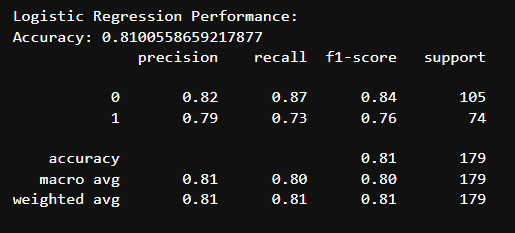

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# предсказания
y_pred_log = log_reg.predict(X_test_scaled)

# вывод репорта
print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

# с моим вариантом качество упало >:(
# сейчас не буду это тестировать, но можно еще попробовать сделать категории по Fair
# еще с майнора по дате помню, кажется, мы возраст делили на десятилетия, а не смысловые категории - тоже можно затестировать потом

Logistic Regression Performance:
Accuracy: 0.7988826815642458
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       105
           1       0.76      0.74      0.75        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



Повторим магию и обучим наивные байесовский классификатор. Что значит `Gaussian` в названии метода `GaussianNB`? Изучите документацию метода, чтобы ответить на этот вопрос

Почему для этого метода не нужен StandardScaler?

**GaussianNB** --- Gaussian предполагает Гауссово (= нормальное) распределение классов. GNB подразумевает, что фичи обладают независимой способностью предсказывать выходную переменную.



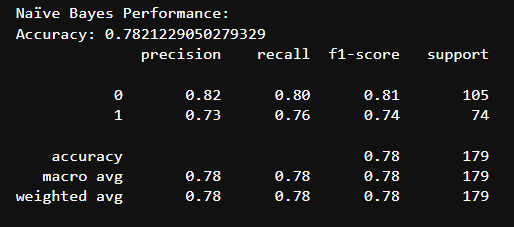

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)

print("Naïve Bayes Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

# О! зато наивный байес лучше стал ٩(◕‿◕｡)۶

Naïve Bayes Performance:
Accuracy: 0.8100558659217877
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       105
           1       0.74      0.84      0.78        74

    accuracy                           0.81       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.81      0.81       179



Мы молодцы! Отрисуем результат с помощью матрицы ошибок (сохраняю, что было в туторе)

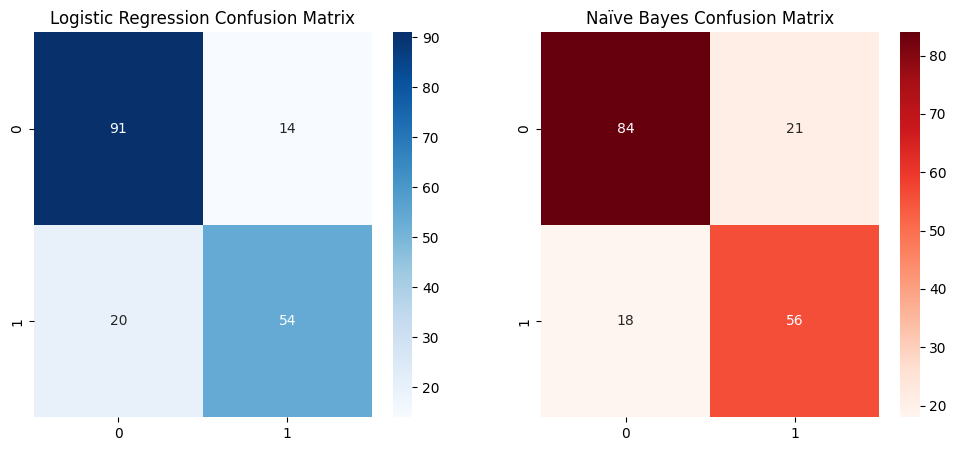

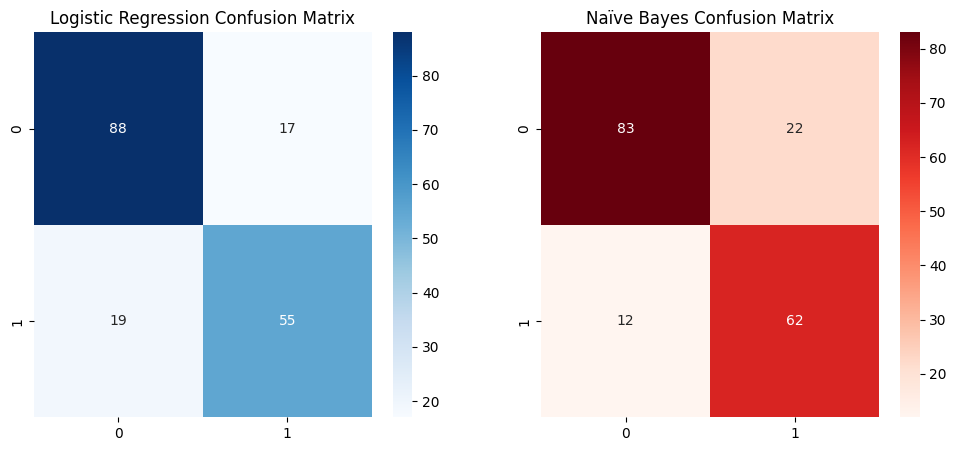

In [ ]:
conf_matrix_log = confusion_matrix(y_test, y_pred_log)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(conf_matrix_log, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Logistic Regression Confusion Matrix")

sns.heatmap(conf_matrix_nb, annot=True, fmt="d", cmap="Reds", ax=axes[1])
axes[1].set_title("Naïve Bayes Confusion Matrix")

plt.show()

# при моих настройках, лог.рег. определила на 1 выжившего больше, наивный байес - на 6 выживших больше
# количество False Positives (False Not Survived) уменьшилось для обеих моделей
# но к сожалению, стало больше False Negatives (False Survived)
# обе модели были склонны присваивать метку 1 (выжил(-а)) и хуже справились с определением погибших